In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree, export_graphviz, export_text

In [3]:
# Path to your CSV file
file_path = 'ciciot-2023.csv'

# Read the CSV file, and immediately change float64 columns to float32
df = pd.read_csv(file_path).astype({col: 'float32' for col in pd.read_csv(file_path, nrows=1).select_dtypes(include=['float64']).columns})

# Now df contains the data from the CSV file with float64 columns converted to float32

In [4]:
for col in df.select_dtypes(include=['object']).columns:
    if df[col].nunique() < df.shape[0] * 0.5:  # Threshold for conversion
        df[col] = df[col].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 28098546 entries, 0 to 28098545

Data columns (total 37 columns):

 #   Column           Dtype   

---  ------           -----   

 0   flow_duration    float32 

 1   Header_Length    float32 

 2   Protocol Type    float32 

 3   Duration         float32 

 4   Rate             float32 

 5   Srate            float32 

 6   fin_flag_number  float32 

 7   syn_flag_number  float32 

 8   rst_flag_number  float32 

 9   psh_flag_number  float32 

 10  ack_flag_number  float32 

 11  ack_count        float32 

 12  syn_count        float32 

 13  fin_count        float32 

 14  urg_count        float32 

 15  rst_count        float32 

 16  HTTP             float32 

 17  HTTPS            float32 

 18  TCP              float32 

 19  UDP              float32 

 20  ICMP             float32 

 21  IPv              float32 

 22  LLC              float32 

 23  Tot sum          float32 

 24  Min              float32 

 25  Max          

In [6]:
df['label'] = df['label'].str.replace('DDoS-UDP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SynonymousIP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-UDP_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-TCP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SYN_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ICMP_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-PSHACK_Flood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-RSTFINFlood', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ICMP_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-SlowLoris', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-ACK_Fragmentation', 'DDoS')
df['label'] = df['label'].str.replace('DDoS-HTTP_Flood', 'DDoS')

df['label'] = df['label'].str.replace('DoS-TCP_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-UDP_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-SYN_Flood', 'DoS')
df['label'] = df['label'].str.replace('DoS-HTTP_Flood', 'DoS')

df['label'] = df['label'].str.replace('Recon-HostDiscovery', 'Recon')
df['label'] = df['label'].str.replace('Recon-OSScan', 'Recon')
df['label'] = df['label'].str.replace('VulnerabilityScan', 'Recon')
df['label'] = df['label'].str.replace('Recon-PortScan', 'Recon')
df['label'] = df['label'].str.replace('Recon-PingSweep', 'Recon')

df['label'] = df['label'].str.replace('XSS', 'Web-Based')
df['label'] = df['label'].str.replace('Uploading_Attack', 'Web-Based')
df['label'] = df['label'].str.replace('BrowserHijacking', 'Web-Based')
df['label'] = df['label'].str.replace('SqlInjection', 'Web-Based')
df['label'] = df['label'].str.replace('CommandInjection', 'Web-Based')
df['label'] = df['label'].str.replace('Backdoor_Malware', 'Web-Based')

df['label'] = df['label'].str.replace('DictionaryBruteForce', 'Brute_Force')

df['label'] = df['label'].str.replace('MITM-ArpSpoofing', 'Spoofing')
df['label'] = df['label'].str.replace('DNS_Spoofing', 'Spoofing')

df['label'] = df['label'].str.replace('Mirai-greip_flood', 'Mirai')
df['label'] = df['label'].str.replace('Mirai-greeth_flood', 'Mirai')
df['label'] = df['label'].str.replace('Mirai-udpplain', 'Mirai')

df['label'] = df['label'].str.replace('BenignTraffic', 'Normal')

In [7]:
print(df['label'].value_counts())

label

DDoS           17567556

DoS             6440023

Mirai           2114210

Normal          1098177

Spoofing         486464

Recon            354223

Web-Based         24829

Brute_Force       13064

Name: count, dtype: int64


In [9]:
# Creating a dictionary of Types
attacks = {'DDoS':0, 'DoS':1, 'Recon':2, 'Web-Based':3,
           'Brute_Force':4, 'Spoofing':5, 'Mirai':6, 'Normal':7}
df['label'] = df['label'].map(attacks)

In [10]:
X = df.drop(columns=['label'])
y = df['label']

In [11]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the original training data for simple validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [13]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Extra Trees model

In [14]:
# Initialize the Extra Trees classifier with default parameters
extra_trees = ExtraTreesClassifier()

# Record the start time for training
start_time = time.time()

# Fit the model on the training data
extra_trees.fit(X_train, y_train)

# Calculate and print the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.3f} seconds')

# Record the start time for prediction
start_time = time.time()

# Make predictions on the test data
y_pred = extra_trees.predict(X_test)

# Calculate and print the testing time
testing_time = time.time() - start_time
print(f'Testing Time: {testing_time:.3f} seconds')

Training Time: 5390.416 seconds

Testing Time: 55.130 seconds


In [15]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9945

Precision: 0.9644

Recall: 0.8474

F1 Score: 0.8891


In [16]:
# Find the unique labels in your test set
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter your attacks dictionary to only include keys with values present in unique_labels
filtered_attacks = {k: v for k, v in attacks.items() if v in unique_labels}

# Now use the filtered attack names as target_names in your classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=list(filtered_attacks.values()), target_names=list(filtered_attacks.keys())))

Classification Report:

              precision    recall  f1-score   support



        DDoS       1.00      1.00      1.00   3513485

         DoS       1.00      1.00      1.00   1287718

       Recon       0.91      0.85      0.88     71339

   Web-Based       0.97      0.49      0.66      4929

 Brute_Force       0.99      0.57      0.73      2556

    Spoofing       0.92      0.88      0.90     97212

       Mirai       1.00      1.00      1.00    422393

      Normal       0.93      0.98      0.95    220078



    accuracy                           0.99   5619710

   macro avg       0.96      0.85      0.89   5619710

weighted avg       0.99      0.99      0.99   5619710




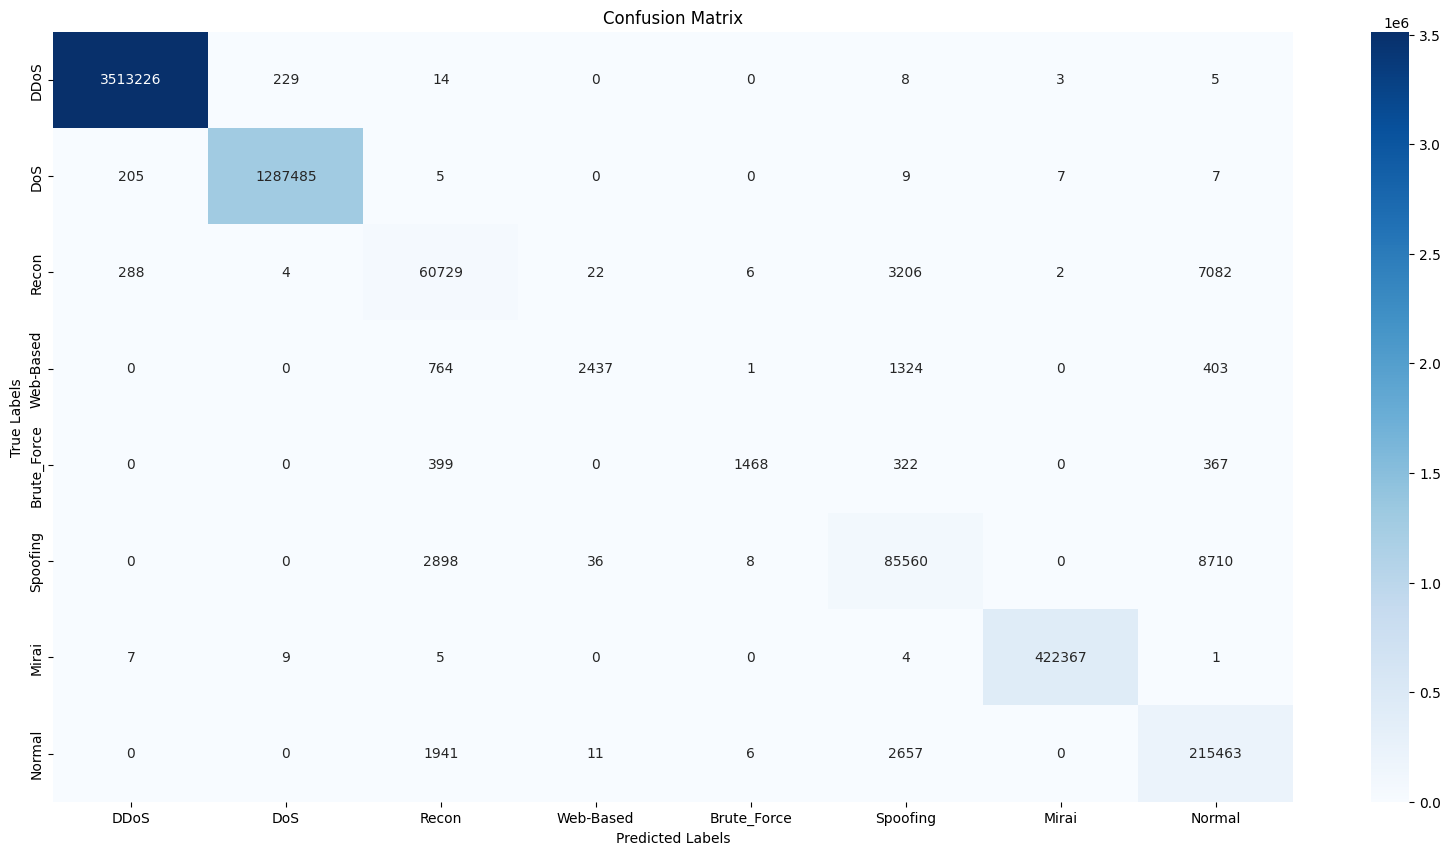

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attacks.keys(), yticklabels=attacks.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

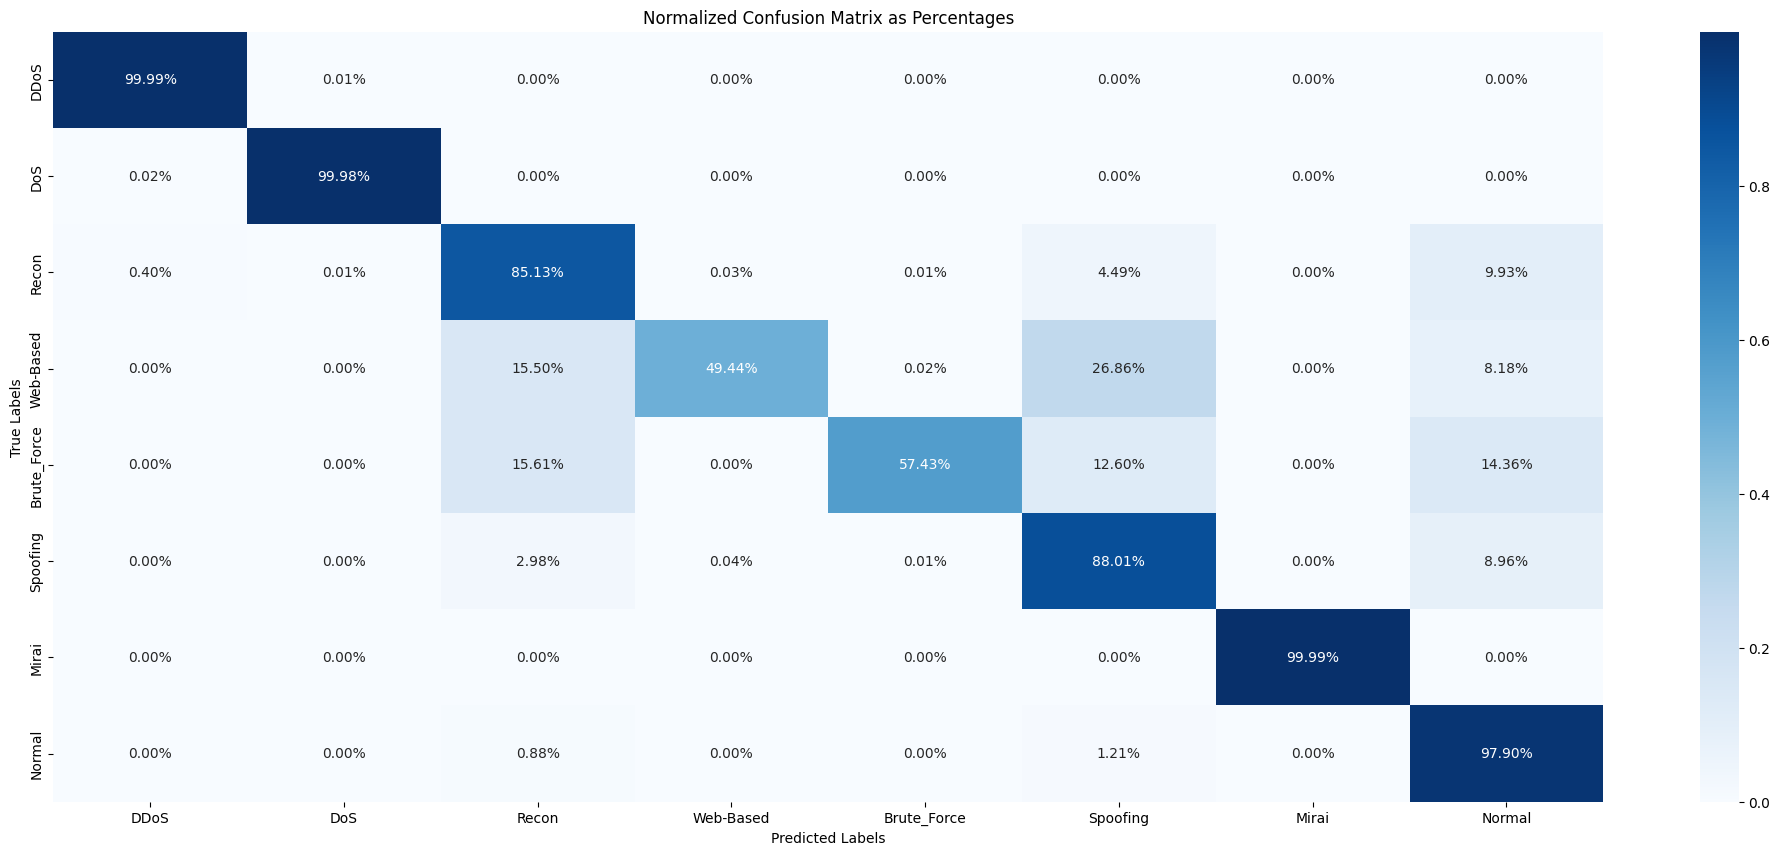

In [18]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(25, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()

# Hyperparameters Optimization

In [20]:
def objective_function(hyperparameters, X_train, y_train):
    # Ensure parameter values are within valid ranges
    n_estimators = max(int(hyperparameters[0]), 1)
    max_depth = None if hyperparameters[1] < 0 else max(int(hyperparameters[1]), 1)
    min_samples_split = max(int(hyperparameters[2]), 2)
    min_samples_leaf = max(int(hyperparameters[3]), 1)
    max_features = max(int(hyperparameters[4]), 1)  # or map to 'auto', 'sqrt', 'log2', None
    bootstrap = hyperparameters[5] > 0.5  # Convert to boolean

    model = ExtraTreesClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                 min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                 max_features=max_features, bootstrap=bootstrap, random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return -accuracy_score(y_val, y_pred)  # Negative accuracy for minimization

# Harmony Search Algorithm

In [21]:
def harmony_search(objective_func, X_train, y_train, memory_size=10, n_iter=100, hmcr=0.9, par=0.3, bw=0.01):
    # Initialize Harmony Memory (HM) with valid ranges
    HM = np.random.rand(memory_size, 6)
    # Scale the random values to match expected ranges of hyperparameters
    # Example scaling for demonstration purposes
    HM[:, 0] *= 190  # n_estimators from 10 to 200
    HM[:, 1] = HM[:, 1] * 19 + 1  # max_depth from 1 to 20
    HM[:, 2] = HM[:, 2] * 9 + 2  # min_samples_split from 2 to 11
    HM[:, 3] = HM[:, 3] * 9 + 1  # min_samples_leaf from 1 to 10
    HM[:, 4] *= 3  # max_features represented as an integer for simplicity
    HM[:, 5] = HM[:, 5] > 0.5  # bootstrap represented as a boolean

    best_score = float('inf')
    best_harmony = None

    for _ in range(n_iter):
        new_harmony = np.zeros(6)
        for i in range(6):
            if np.random.rand() < hmcr:  # Harmony Memory Consideration Rate
                new_harmony[i] = HM[np.random.randint(0, memory_size), i]
                if np.random.rand() < par:  # Pitch Adjustment Rate
                    new_harmony[i] += bw * (np.random.rand() - 0.5) * 2
            else:
                # Randomly initialize this parameter
                if i == 5:  # Bootstrap parameter
                    new_harmony[i] = np.random.rand() > 0.5
                else:
                    lower_bound, upper_bound = 10, 200  # Example bounds, adjust for each parameter
                    new_harmony[i] = np.random.rand() * (upper_bound - lower_bound) + lower_bound

        # Ensure new harmony is within valid ranges
        new_harmony[0] = max(int(new_harmony[0]), 10)  # n_estimators
        new_harmony[1] = max(int(new_harmony[1]), 1)  # max_depth
        new_harmony[2] = max(int(new_harmony[2]), 2)  # min_samples_split
        new_harmony[3] = max(int(new_harmony[3]), 1)  # min_samples_leaf
        new_harmony[4] = max(int(new_harmony[4]), 1)  # max_features as integer

        score = objective_func(new_harmony, X_train, y_train)

        # Update Harmony Memory and best harmony if necessary
        if score < best_score:
            best_score = score
            best_harmony = new_harmony

        # Update Harmony Memory (HM) if the new harmony is better than the worst harmony in HM
        worst_idx = np.argmax([objective_func(HM[i, :], X_train, y_train) for i in range(memory_size)])
        if score < objective_func(HM[worst_idx, :], X_train, y_train):
            HM[worst_idx, :] = new_harmony

    return best_harmony

In [22]:
def map_max_features(value):
    # Assuming 'value' is a continuous variable from 0 to 1 obtained from harmony search
    if value < 0.25:
        return 'auto'  # or 'sqrt'
    elif value < 0.5:
        return 'log2'
    elif value < 0.75:
        # Maps to a fraction of features, e.g., 0.5 for half of the features
        return 0.5
    else:
        # Use all features
        return None

# Optimized Extra Trees

In [ ]:
# Optimize hyperparameters
best_hyperparams = harmony_search(objective_function, X_train, y_train)

# Train the Extra Trees model with optimized hyperparameters
# Use the optimized hyperparameters to configure the Extra Trees model
optimized_model = ExtraTreesClassifier(
    n_estimators=int(best_hyperparams[0]),
    max_depth=None if best_hyperparams[1] < 0 else int(best_hyperparams[1]),
    min_samples_split=int(best_hyperparams[2]),
    min_samples_leaf=int(best_hyperparams[3]),
    max_features=map_max_features(best_hyperparams[4]),  # Ensure this function maps to valid values
    bootstrap=bool(best_hyperparams[5]),
    random_state=42
)

print(f"Best Hyperparameters: {best_hyperparams}")

# Record the start time for training
start_time = time.time()

optimized_model.fit(X_train, y_train)

# Calculate and print the training time
training_time = time.time() - start_time
print(f'Training Time: {training_time:.3f} seconds')

# Record the start time for prediction
start_time = time.time()

# Evaluate the optimized model
y_pred = optimized_model.predict(X_test)

# Calculate and print the testing time
testing_time = time.time() - start_time
print(f'Testing Time: {testing_time:.3f} seconds')

In [ ]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [ ]:
# Find the unique labels in your test set
unique_labels = np.unique(np.concatenate((y_test, y_pred)))

# Filter your attacks dictionary to only include keys with values present in unique_labels
filtered_attacks = {k: v for k, v in attacks.items() if v in unique_labels}

# Now use the filtered attack names as target_names in your classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, labels=list(filtered_attacks.values()), target_names=list(filtered_attacks.keys())))

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(20, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=attacks.keys(), yticklabels=attacks.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(25, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()

In [ ]:
print(optimized_model)